In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
# loading in dataset as pandas dataframe
#
incidentData = pd.read_csv("/Users/luke/Downloads/incidents_part1_part2.csv")


['the_geom', 'cartodb_id', 'the_geom_webmercator', 'objectid', 'dc_dist', 'psa', 'dispatch_date_time', 'dispatch_date', 'dispatch_time', 'hour', 'dc_key', 'location_block', 'ucr_general', 'text_general_code', 'point_x', 'point_y', 'lat', 'lng']


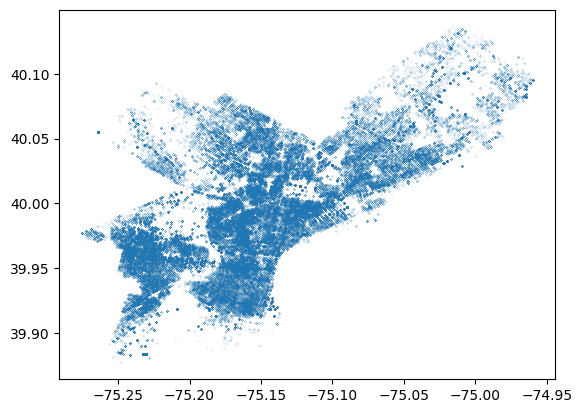

In [2]:
# viewing all the fields of the dataframe
#
print(incidentData.columns.tolist())
# isolating the X and Y coordinates of the police incidents
#
incidentX = incidentData['point_x']
incidentY = incidentData['point_y']
# I figured this would be cool- I plotted all the incidents in the dataset
#
plt.scatter(incidentX,incidentY, s=0.005)
plt.show()

/Users/luke/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


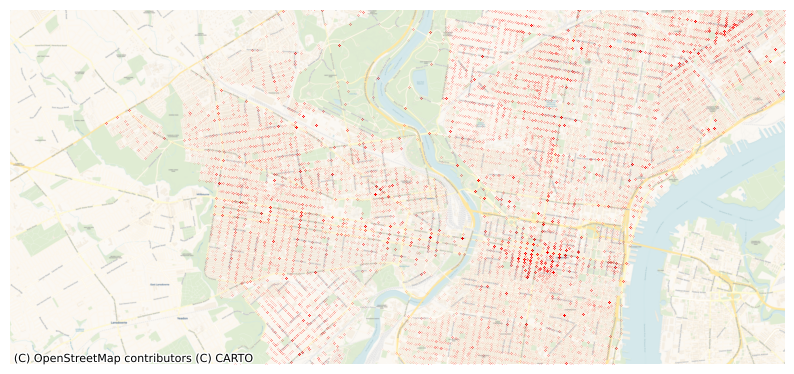

In [3]:
# I'm going to try something cooler
# I found these libraries called geopandas and contextily that let you map out data and put it on a geographical map
#
import geopandas as gpd
from shapely.geometry import Point
import contextily

# chatGPT helped me with a lot of this bit
# create a GeoDataFrame- this I'm not too sure of
#
geometry = [Point(xy) for xy in zip(incidentX, incidentY)]
geo_df = gpd.GeoDataFrame(zip(incidentX, incidentY), geometry=geometry)

# set coordinate reference system so that the map will actually show up (this is a very important step- the map did not show properly without this)
#
geo_df.set_crs(epsg=4326, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))

# set the limits for the map to cover Philadelphia
#
ax.set_xlim(-75.30, -75.10)
ax.set_ylim(39.93, 40.00)

# add a map as backgroud to place the data - I tried some of the providers and this was the cleanest one I found
#
contextily.add_basemap(ax, crs=geo_df.crs, source=contextily.providers.CartoDB.Voyager, zoom=15)

# I'm adding points to the plot- I'm making them really small because there are a lot
#
geo_df.plot(ax=ax, marker='o', color='red', markersize=0.0005, alpha=0.5)
ax.axis('off')
plt.show()

That doesn't look too bad. It seems like one of the hotspots is near City Hall, and in the Northeast. I might play around with this later in the project.

For the first question of the project, I am going to attempt to model the data as a Poisson process.

In [4]:
from datetime import datetime, timedelta
#
# first, I want to grab all the incident times, and store them in an array, these will function as the arrival times for the Poisson Process
# I used a one liner for this- it is looping through each datetime in the dispatch date time data column, 
# stripping the time zone offset since all of our data is from the same time zone, 
# then converting the datetime from a string to a datetime object so that we can do math with them later
# after this, I am sorting the list in chronological order, since my output was not appearing in chronological order before
#
arrivalTimes = sorted([datetime.strptime(time.replace('+00',''), '%Y-%m-%d %H:%M:%S') for time in incidentData['dispatch_date_time']])
#
# there's one issue with this data in my opinion- it is only recording the dispatch time, not the actual reported time of the incident (if I am understanding the metadata correctly) 
# There shouldn't be a huge discrepancy between the two for the most part, unless there are a lot of incidents happening at the same time, causing there to not be officers avaiable to dispatch. I would think this is very unlikely though.
# ^ However, I'm assuming for a dispatch to occur, someone must call 911, then relay the situation and location to the operator, which will take more or less time depending on the situation.
# 
#print(arrivalTimes)
# next, calculate the intervals between each arrival and store in a list:
#
arrivalIntervals = []
currentMax = timedelta(0)
for i, time in enumerate(arrivalTimes):
    # if at first arrival, skip
    #
    if i == 0:
        continue
    # else calculate time between current arrival and previous
    #
    else:
        # calculate time difference
        #
        diff = arrivalTimes[i] - arrivalTimes[i-1]
        # convert time difference to seconds and store in list
        #
        arrivalIntervals.append(int(diff.total_seconds()))
# calculate average interval time in seconds
#
totalInterval = sum(arrivalIntervals)
avgInterval = totalInterval/len(arrivalIntervals)
print(avgInterval)

208.5727891426417


This means that a new incident occurs every 208.573 seconds on average (using the entire dataset). Next, I'm going to find the arrival rate per week.

In [5]:
# divide the total number of incidents in a year by the number of weeks per year
#
arrivalRate = len(incidentData) / 52.1429
print(arrivalRate)

2899.6852879299004


This means ~2900 incidents occur every year. I'm going to use this to generate a Poisson process.

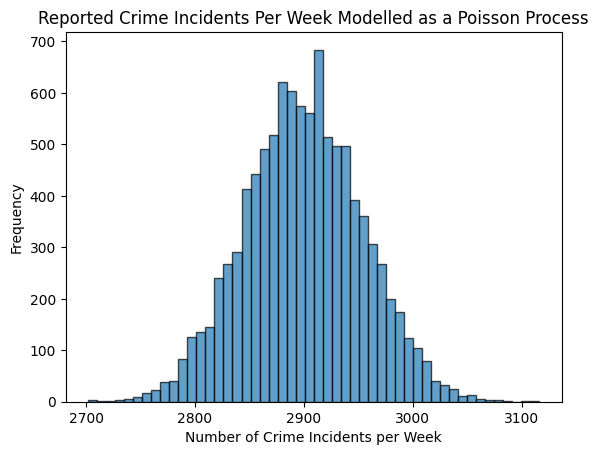

"\n# one-liner to convert arrival datetimes to just dates\n#\narrivalDf['arrival_time'] = [val.date() for i, val in enumerate(arrivalDf['arrival_time'])]\n"

In [55]:
import numpy as np
incidentsPoisson = np.random.poisson(lam = arrivalRate, size=10000)

# next, group arrivalTimes into weeks
#
arrivalDf = pd.DataFrame(arrivalTimes, columns=['arrival_time'])
# plotting poisson process
#
plt.hist(incidentsPoisson, bins=50,edgecolor='black', alpha=0.7)
plt.title('Reported Crime Incidents Per Week Modelled as a Poisson Process')
plt.xlabel("Number of Crime Incidents per Week")
plt.ylabel("Frequency")
plt.show()

This are the frequencies of each number of incidents per week from the Poisson process. Next, I will use scipy to make a Poisson PMF:

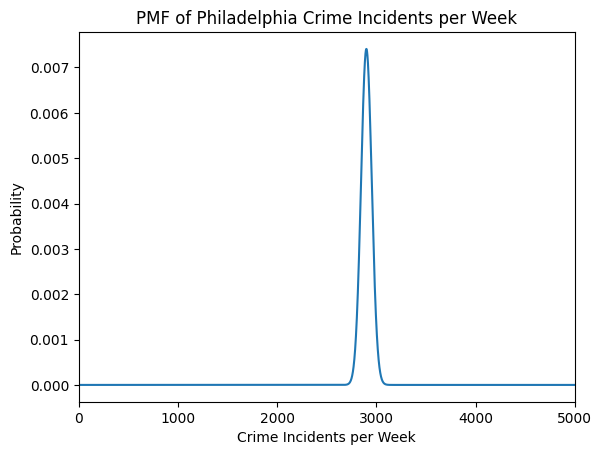

In [69]:
from scipy.stats import poisson
# generate Poisson PMF
#
poissonPMF = poisson.pmf(np.arange(0,len(incidentData)), arrivalRate)
# plot Poisson PMF
#
plt.plot(poissonPMF)
plt.xlim(0,5000)
plt.xlabel("Crime Incidents per Week")
plt.ylabel("Probability")
plt.title("PMF of Philadelphia Crime Incidents per Week")
plt.show()

QUESTION 2:

Select (at least) three columns that you think might be interesting and compute the correlation (not covariance) between the columns

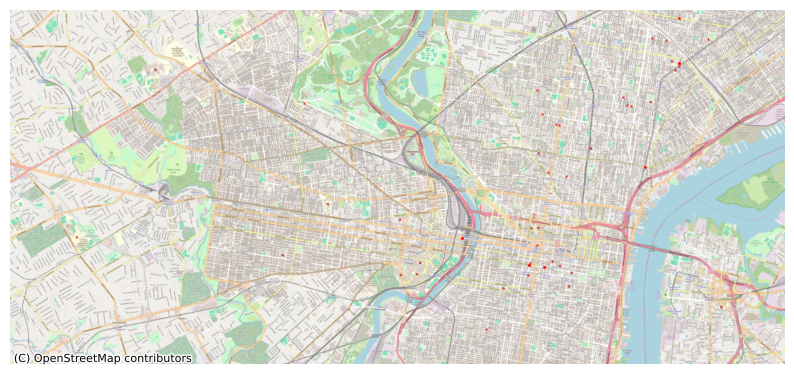

In [7]:
# I'm going to try to find the correlation between the type of crime and the location that the crime occurs
# this is convenient since the crimes are already number-coded. For location I will use the x column and the y column
#
# first, I am going to do a little visualization test. I am going to plot all of the public drunkeness violations on my map from earlier
# and see if the results follow any sort of pattern
#
# chatGPT helped me with a lot of this bit
# create a GeoDataFrame- this I'm not too sure of
#
drunkenData = incidentData[incidentData['ucr_general'].between(2300, 2399)]

drunkenX = drunkenData['point_x']
drunkenY = drunkenData['point_y']
geometry = [Point(xy) for xy in zip(drunkenX, drunkenY)]
geo_df = gpd.GeoDataFrame(zip(drunkenX, drunkenY), geometry=geometry)

# set coordinate reference system so that the map will actually show up (this is a very important step- the map did not show properly without this)
#
geo_df.set_crs(epsg=4326, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))

# set the limits for the map to cover Philadelphia
#
ax.set_xlim(-75.30, -75.10)
ax.set_ylim(39.93, 40.00)

# add a map as backgroud to place the data - I tried some of the providers and this was the cleanest one I found
#
contextily.add_basemap(ax, crs=geo_df.crs, source=contextily.providers.OpenStreetMap.Mapnik, zoom=15)

# I'm adding points to the plot- I'm making them really small because there are a lot
#
geo_df.plot(ax=ax, marker='o', color='red', markersize=1, alpha=0.5)
ax.axis('off')
#plt.savefig('./drunkMap.png')
plt.show()


There are only 48 occurences of crimes that fall into the Public Drunkeness category of violations, but there seems to be a cluster slightly Southeast of City Hall. There are some popular bars located there, so I am assuming this is what is causing this cluster here. It would be interesting to do this experiment with more data...

In [8]:
# I downloaded more years of data from the site. Since we are looking for public drunkenness, I skipped 2020 entirely because of COVID
#
incidentData2024 = pd.read_csv("/Users/luke/Downloads/incidents_part1_part22024.csv")
incidentData2023 = pd.read_csv("/Users/luke/Downloads/incidents_part1_part22023.csv")
incidentData2021 = pd.read_csv("/Users/luke/Downloads/incidents_part1_part22021.csv")
incidentData2019 = pd.read_csv("/Users/luke/Downloads/incidents_part1_part22019.csv")
incidentData2018 = pd.read_csv("/Users/luke/Downloads/incidents_part1_part22018.csv")
incidentData2017 = pd.read_csv("/Users/luke/Downloads/incidents_part1_part22017.csv")
incidentData2016 = pd.read_csv("/Users/luke/Downloads/incidents_part1_part22016.csv")
incidentData2015 = pd.read_csv("/Users/luke/Downloads/incidents_part1_part22015.csv")
# adding new data to 2022 dataframe
#
incidentData = pd.concat([incidentData, incidentData2024], axis=0)
incidentData = pd.concat([incidentData, incidentData2023], axis=0)
incidentData = pd.concat([incidentData, incidentData2021], axis=0)
incidentData = pd.concat([incidentData, incidentData2019], axis=0)
incidentData = pd.concat([incidentData, incidentData2018], axis=0)
incidentData = pd.concat([incidentData, incidentData2017], axis=0)
incidentData = pd.concat([incidentData, incidentData2016], axis=0)
incidentData = pd.concat([incidentData, incidentData2015], axis=0)
# storing in different name for later use
#
fullData = incidentData
# grabbing all public drunkeness violations
#
drunkenData = incidentData[incidentData['ucr_general'].between(2300, 2399)]
print(drunkenData.shape)

(1494, 18)


While this still isn't a lot of data, this gives us a little more to work with. I'm going to remake my public drunkeness map:

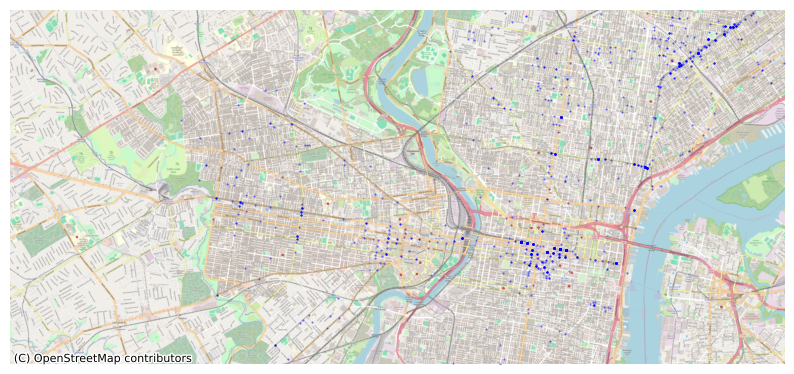

In [9]:
drunkenX = drunkenData['point_x']
drunkenY = drunkenData['point_y']
geometry = [Point(xy) for xy in zip(drunkenX, drunkenY)]
geo_df = gpd.GeoDataFrame(zip(drunkenX, drunkenY), geometry=geometry)

# set coordinate reference system so that the map will actually show up (this is a very important step- the map did not show properly without this)
#
geo_df.set_crs(epsg=4326, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))

# set the limits for the map to cover Philadelphia
#
ax.set_xlim(-75.30, -75.10)
ax.set_ylim(39.93, 40.00)

# add a map as backgroud to place the data - I tried some of the providers and this was the cleanest one I found
#
contextily.add_basemap(ax, crs=geo_df.crs, source=contextily.providers.OpenStreetMap.Mapnik, zoom=15)

# I'm adding points to the plot- I'm making them really small because there are a lot
#
geo_df.plot(ax=ax, marker='o', color='blue', markersize=0.3, alpha=0.5)
ax.axis('off')
#plt.savefig('./drunkMap.png')
plt.show()

I checked the hotspots on this map, and it seems there are a few big ones. One is slightly Southeast of City Hall and one is in Fishtown. Both of these areas have a lot of bars. Another huge hotspot is Kensington. University City also has a few smaller hotspots. 

Based on this experiment, and the fact that public drunkeness crimes are centered around key nightlife areas (and Kensington), I believe that certain crimes are more common in certain areas, so I expect to see a high correlation between the type of crime commited and the location of the crimes being reported.

In [10]:
# first, I'm going to clear that data
#
del(incidentData)
# reload original data
#
incidentData = pd.read_csv("/Users/luke/Downloads/incidents_part1_part2.csv")
print(incidentData[['point_x', 'point_y', 'ucr_general']].corr())


              point_x   point_y  ucr_general
point_x      1.000000  0.633941    -0.055576
point_y      0.633941  1.000000    -0.026984
ucr_general -0.055576 -0.026984     1.000000


These results do not support my hypothesis. The correlation between the location of the crime and the type of crime is very low. I think this is because my previous experiment was not quite correct for what I was testing. If I wanted to test if correlation would be high between the type of crime and the location of the crime, I should have found two types of crimes that have different hotspots. This would prove that the location is linked to the type of crime. To see if I have any luck with this, I am going to use my large dataset to look at hotspots for homicides, and see if they are any different to my public drunkeness hotspots. I am guessing there will still be a decent amount of overlap due to intoxication making crime more likely.

In [11]:
murderData = fullData[fullData['ucr_general'].between(100, 116)]
murderX = murderData['point_x']
murderY = murderData['point_y']
geometry = [Point(xy) for xy in zip(murderX, murderY)]
geo_df = gpd.GeoDataFrame(zip(murderX, murderY), geometry=geometry)

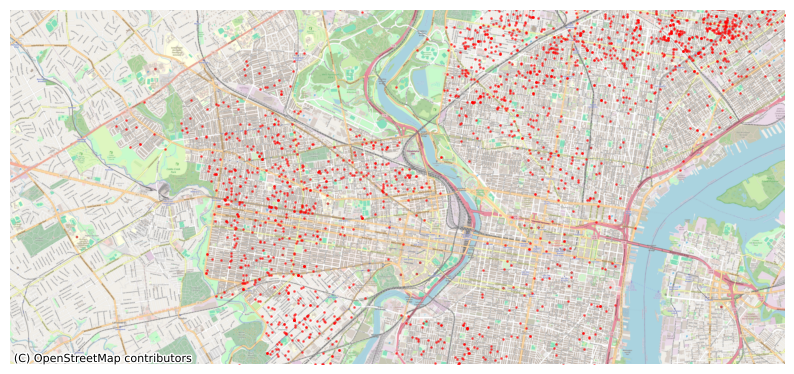

In [12]:
# set coordinate reference system so that the map will actually show up (this is a very important step- the map did not show properly without this)
#
geo_df.set_crs(epsg=4326, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))

# set the limits for the map to cover Philadelphia
#
ax.set_xlim(-75.30, -75.10)
ax.set_ylim(39.93, 40.00)

# add a map as backgroud to place the data - I tried some of the providers and this was the cleanest one I found
#
contextily.add_basemap(ax, crs=geo_df.crs, source=contextily.providers.OpenStreetMap.Mapnik, zoom=15)

# I'm adding points to the plot- I'm making them really small because there are a lot
#
geo_df.plot(ax=ax, marker='o', color='red', markersize=1, alpha=0.5)
ax.axis('off')
#plt.savefig('./drunkMap.png')
plt.show()

This is a little strange. It seems like the homicide data does not follow the same trend as the public drunkeness data, but it has its own hotspots. This should mean that it is more likely that the type of crime and the location of the crime are correlated in some way, but my previous results do not reflect that. I'm guessing this may be because the correlation calculation is find the correlation of the type of crime with the x coordinate, then the correlation of the type of crime with the y coordinate, which may not give a good measurement of correlation between the type of crime and the location of the crime.

Another interesting note is that the murders (generally) get less frequent as you get closer to the center of the city, and become increasingly more frequent the further you get. The public drunkeness data did not follow this trend. 

QUESTION 3:
Select (at least) three columns that you think might be interesting and test whether the data falls into natural clusters. You will have to use either k-means or expectation-maximization (there are pre-built Python libraries for both). How many clusters is a good model for the data? Is there any intuitive reason why the data should cluster?

For this, I am going to backtrack and use my public drunkeness example. I'm going to use k-means to cluster the datapoints based on location.

In [13]:
from scipy.cluster.vq import kmeans, vq
import numpy as np
# initliazing K Means- I am using 4 clusters since there appeared to be roughly 4 in previous test with the public drunkeness data
#
#kmeans = KMeans(n_clusters = 4)
# I found some NaNs in my x and y data, so I'm getting rid of them here
#
cleanDrunkenX = drunkenX.dropna()
cleanDrunkenY = drunkenY.dropna()
data = list(zip(cleanDrunkenX, cleanDrunkenY))
# fitting kmeans to data- I used this library because the sklearn KMeans was not importing correctly
#
centroids, _ = kmeans(data, 4)
# label data 
#
labels, _ = vq(data, centroids)
# splitting labeled data into separate lists for plotting
#
labeledX = [[],[],[],[]]
labeledY = [[],[],[],[]]
for i, value in enumerate(data):
    currentLabel = labels[i]
    labeledX[currentLabel].append(value[0])
    labeledY[currentLabel].append(value[1])

Now that we have the data labeled, I'm going to plot the labeled points over my map of Philly.

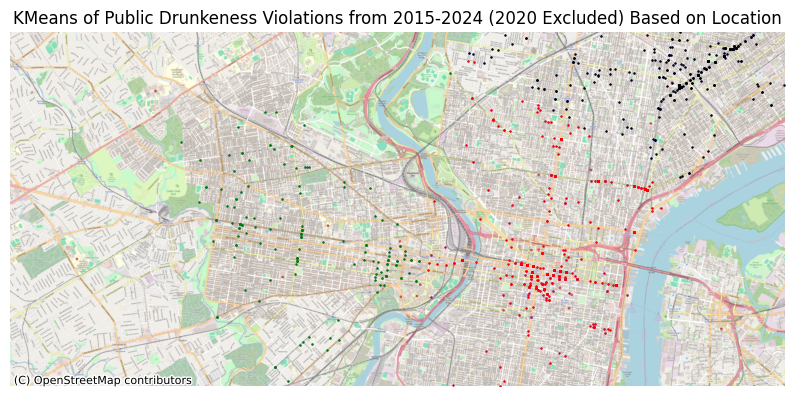

In [14]:
drunkenX = drunkenData['point_x']
drunkenY = drunkenData['point_y']
geometry = [Point(xy) for xy in zip(drunkenX, drunkenY)]
geo_df = gpd.GeoDataFrame(zip(drunkenX, drunkenY), geometry=geometry)

# set coordinate reference system so that the map will actually show up (this is a very important step- the map did not show properly without this)
#
geo_df.set_crs(epsg=4326, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))

# set the limits for the map to cover Philadelphia
#
ax.set_xlim(-75.30, -75.10)
ax.set_ylim(39.93, 40.00)

# add a map as backgroud to place the data - I tried some of the providers and this was the cleanest one I found
#
contextily.add_basemap(ax, crs=geo_df.crs, source=contextily.providers.OpenStreetMap.Mapnik, zoom=15)

# for some reason the map breaks if this line isn't there.
#
geo_df.plot(ax=ax, marker='o', color='blue', markersize=0.3, alpha=0.5)
ax.axis('off')

plt.scatter(labeledX[0],labeledY[0], color='red', s=0.5)
plt.scatter(labeledX[1],labeledY[1], color='black', s=0.5)
plt.scatter(labeledX[2],labeledY[2], color='green', s=0.5)
plt.scatter(labeledX[3],labeledY[3], color='purple', s=0.5)

plt.title('KMeans of Public Drunkeness Violations from 2015-2024 (2020 Excluded) Based on Location')
plt.show()

It doesn't seem like the second cluster is present in the plot.

In [15]:
print(len(labeledY[1]))
print(len(labeledX[1]))

430
430


It seems like it's the result of a weird plotting error since the lists for that cluster are not empty. To observe all the clusters, I am just going to plot them with a normal scatter plot

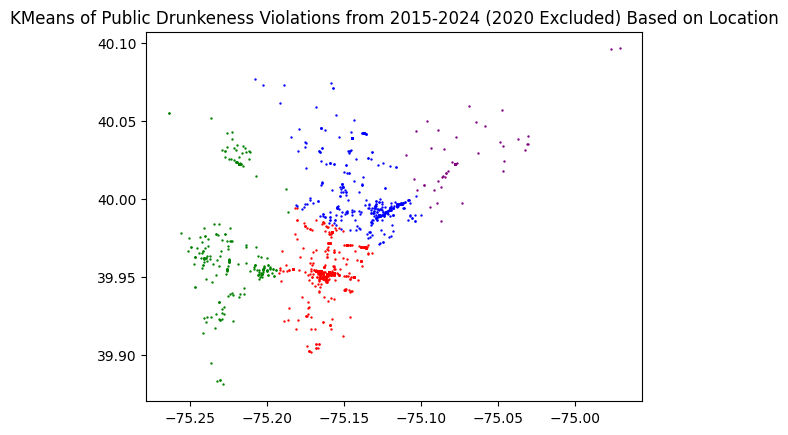

In [16]:
plt.scatter(labeledX[0],labeledY[0], color='red', s=0.5)
plt.scatter(labeledX[1],labeledY[1], color='blue', s=0.5)
plt.scatter(labeledX[2],labeledY[2], color='green', s=0.5)
plt.scatter(labeledX[3],labeledY[3], color='purple', s=0.5)
plt.title('KMeans of Public Drunkeness Violations from 2015-2024 (2020 Excluded) Based on Location')
plt.show()

It seems like the second cluster is just some points weakly grouped in the top right. I believe this means that the current 3 clusters shown on the map of Philadelphia are the strongest ones. This makes sense, as the first cluster, shown in green, holds the points in the Center City area. The points shown in red are from the University City area, and the points shown in purple are the Kensington data points. I am going to try KMeans with more clusters.

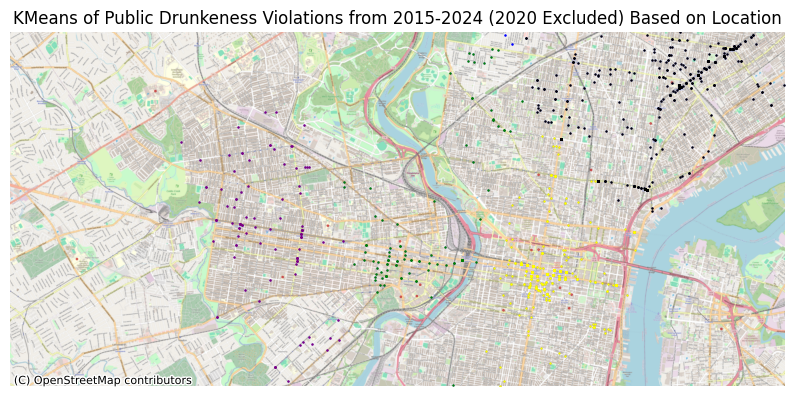

In [17]:
centroids, _ = kmeans(data, 7)
# label data 
#
labels, _ = vq(data, centroids)
# splitting labeled data into separate lists for plotting
#
labeledX = [[],[],[],[],[],[],[]]
labeledY = [[],[],[],[],[],[],[]]
for i, value in enumerate(data):
    currentLabel = labels[i]
    labeledX[currentLabel].append(value[0])
    labeledY[currentLabel].append(value[1])
    geometry = [Point(xy) for xy in zip(drunkenX, drunkenY)]
geo_df = gpd.GeoDataFrame(zip(drunkenX, drunkenY), geometry=geometry)
# set coordinate reference system so that the map will actually show up (this is a very important step- the map did not show properly without this)
#
geo_df.set_crs(epsg=4326, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))
# set the limits for the map to cover Philadelphia
#
ax.set_xlim(-75.30, -75.10)
ax.set_ylim(39.93, 40.00)

# add a map as backgroud to place the data - I tried some of the providers and this was the cleanest one I found
#
contextily.add_basemap(ax, crs=geo_df.crs, source=contextily.providers.OpenStreetMap.Mapnik, zoom=15)

# for some reason the map breaks if this line isn't there.
#
geo_df.plot(ax=ax, marker='o', color='blue', markersize=0.3, alpha=0.5)
ax.axis('off')

plt.scatter(labeledX[0],labeledY[0], color='red', s=0.5)
plt.scatter(labeledX[1],labeledY[1], color='orange', s=0.5)
plt.scatter(labeledX[2],labeledY[2], color='green', s=0.5)
plt.scatter(labeledX[3],labeledY[3], color='purple', s=0.5)
plt.scatter(labeledX[4],labeledY[4], color='blue', s=0.5)
plt.scatter(labeledX[5],labeledY[5], color='yellow', s=0.5)
plt.scatter(labeledX[6],labeledY[6], color='black', s=0.5)
plt.title('KMeans of Public Drunkeness Violations from 2015-2024 (2020 Excluded) Based on Location')
plt.show()

Now it seems that there are 4 main clusters. There are the 3 present in the previous map plot, Center City, Kensington, and Univeristy City. But now, there is another large cluster that encapsulates North Philly and Fishtown. I was expecting this from the first map plot with 4 clusters, as Fishtown was another large hotspot that I saw with this data. This is pretty intuitive, as the clusters cover 3 large nightlife areas in Philadelphia (and Kensington). I expected to see the clusters centered around popular bar/club areas in Philly, which we are kind of seeing here.

QUESTION 4: 
Can you find a variable that is modeled as a binomial process? Present evidence for why or why not.

I am going to attempt to model motor vehicle theft as a binomial process. So, with each incident, it will be considered a 'success' if it is a motor vehicle theft, and a 'failure' if it is any other type of incident.

#

0.07817563724387888


/Users/luke/Library/Python/3.9/lib/python/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


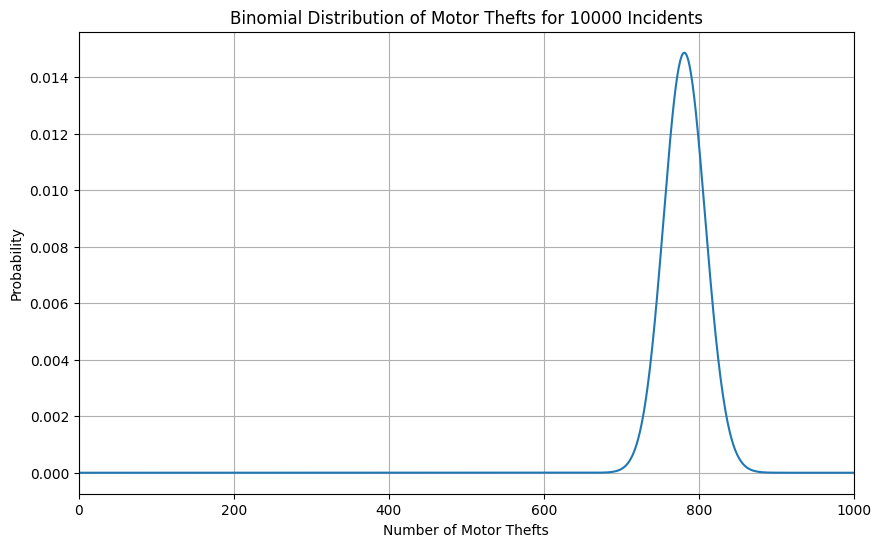

In [44]:
# First, find the probability that an event is a motor vehicle theft
# count the number of motor thefts
from scipy.stats import binom
# reloading data because something weird was happening
#
incidentData = pd.read_csv("/Users/luke/Downloads/incidents_part1_part2.csv")
motorTheftsCount = 0
for i, code in enumerate(incidentData['ucr_general']):
    if(code == 700):
        motorTheftsCount += 1
# calculate probability of motor theft
#
probMotorTheft = motorTheftsCount/len(incidentData)
print(probMotorTheft)
# generate binomial process for 10000 incidents
#
motorTheftBinomial = binom(p=probMotorTheft, n=10000)
# extract pmf from binomial process (I used 1000 points here because plotting with 10000 doesn't look great)
#
x = np.arange(0, 10000, 1)
motorTheftPMF = motorTheftBinomial.pmf(x)
# plot pmf
#
plt.figure(figsize=(10, 6))
plt.xlim(0,1000)
plt.plot(x, motorTheftPMF)
plt.title("Binomial Distribution of Motor Thefts for 10000 Incidents")
plt.xlabel("Number of Motor Thefts")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


This looks alright. This curve is showing that the probability peaks around 775 motor thefts per 10000 incidents. Let's test this with some samples from our data.

In [48]:
import random
# loop through incidents and count all occurences of motor thefts for groups of 10k incidents- stores counts in bins
#

bins = [0]
binsCount = 0
# shuffle incidents
#
shuffledIncidents = incidentData.sample(frac=1).reset_index(drop=True)
print(len(shuffledIncidents))
# loop and track index
#
for i, incident in enumerate(shuffledIncidents['ucr_general']):
    # check if 10k incidents were just counted
    #
    if(i > 0 and i % 10000 == 0):
        bins.append(0)
        binsCount += 1
    # if incident is a motor theft, add to count
    #
    if(incident == 700):
        bins[binsCount] += 1
# last count is not for full 10k, remove it
#
bins = bins[:-1]
bins = np.array(bins)
print(bins)
print(np.mean(bins))

151198
[786 793 797 770 752 809 768 771 852 764 748 817 769 819 725]
782.6666666666666


These numbers don't look too bad. The average motor theft count per 10k crime incident is very close to the observed value from the binomial distribution. Let's find the PMF for this:

[0.0786, 0.0793, 0.0797, 0.077, 0.0752, 0.0809, 0.0768, 0.0771, 0.0852, 0.0764, 0.0748, 0.0817, 0.0769, 0.0819, 0.0725]


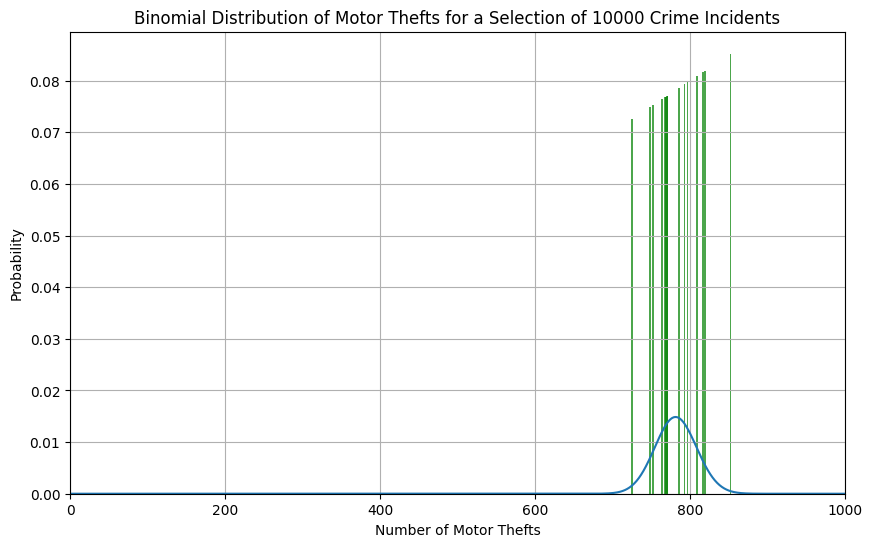

In [73]:
# calculate PMF of measured data
#
measuredPMF = [count / 10000 for count in bins]
print(measuredPMF)
plt.figure(figsize=(10, 6))
plt.plot(x, motorTheftPMF)
#plt.bar(measuredPMF)
plt.bar(bins, measuredPMF, color='g', alpha=0.7, width=2)
plt.title("Binomial Distribution of Motor Thefts for a Selection of 10000 Crime Incidents")
plt.xlabel("Number of Motor Thefts")
plt.ylabel("Probability")
plt.grid(True)
plt.xlim(0,1000)
plt.show()

It seems like the probabilities I'm calculating from the data are a lot higher than the PMF values generated from the binomial distribution. This is weird because the data points are very close to my calculated probability for the binomial distribution. There may be a flaw in how I calculated either the PMF for the binomial distribution or the measured data. Still, the average motor theft counts observed from the binomial distribution and the measured data are very close, which gives me hope that this binomial approach for incident types could work.

QUESTION 5: 
Based on the data, what advice can you offer citizens who want to avoid car accidents or crime?

From observing the map of murders in Philadelphia generated earlier in the project, it seems one of the best ways to try to avoid violent crime in Philadelphia is to stay close to the Center City. The closer you get to the city limits, it seems violent crime becomes more and more likely. Also, a good general note to avoid all crime is to avoid Kensington. This was a major hotspot for every type of crime that I observed. It seems that some crimes, such as public drunkeness, do not follow the same trend as the violent crime locations, where violent crime becomes more likely as you get closer to the city limits. Based on my findings, I would assert that the more delinquent crimes would still be frequent closer to the center of the city, and would tend to be gathered around certain locational hotspots, such as bar areas. 